In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from scipy import ndimage as ndi

from skimage import (
    exposure, io, morphology, color, feature, filters, util, segmentation
)
import math
#import napari
#from napari.utils import nbscreenshot
from scipy import signal
from skimage.filters import threshold_multiotsu
from skimage.filters import try_all_threshold, gaussian
from skimage.morphology import disk
from skimage.filters import threshold_li
from skimage import measure
import pandas as pd
import os
#import PyDIP as dip
import math
import re
from glob import glob
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.segmentation import random_walker, clear_border
from scipy import ndimage
from skimage.measure import label, regionprops, regionprops_table
from skimage.exposure import histogram

In [14]:
def slice(im3d):
    stack_size = im3d.shape[0]
    hist=[]
    for i in range(stack_size):
        hist.append(im3d[i,:,:].mean())
    plt.plot(range(stack_size),hist, '.-')
    #if len(signal.argrelextrema(np.array(hist), np.greater)) <= 2:
    grad1 = np.gradient(hist)
    peaks, ups = signal.find_peaks(grad1,max(grad1)*0.1)
    peaks2, ups2 = signal.find_peaks(hist,max(hist)*0.1)
    #plt.vlines([maximums],0,max(hist), colors='r')
    plt.vlines([peaks2],0,max(hist), colors='b')
    chosen=[]
    for i in range(stack_size):
        if hist[i] >= (ups['peak_heights'][0]+2*ups2['peak_heights'][0])/3:
            plt.vlines(i,0,max(hist), colors='y')
            chosen.append(i)
    return chosen

In [15]:
def slice_manual(im3d,start,stop):
    stack_size = im3d.shape[0]
    hist=[]
    for i in range(stack_size):
        hist.append(im3d[i,:,:].mean())
    plt.plot(range(stack_size),hist, '.-')
    #if len(signal.argrelextrema(np.array(hist), np.greater)) <= 2:
    grad1 = np.gradient(hist)
    peaks, ups = signal.find_peaks(grad1,max(grad1)*0.1)
    peaks2, ups2 = signal.find_peaks(hist,max(hist)*0.1)
    #plt.vlines([maximums],0,max(hist), colors='r')
    plt.vlines([peaks2],0,max(hist), colors='b')
    chosen = range(start,stop)
    for i in chosen:
        plt.vlines(i,0,max(hist), colors='y')
    return chosen

In [16]:
def display(im3d, cmap="gray", step=1, chosen = None):
    if chosen is None: 
        chosen = []
    stack_size = im3d.shape[0]
    cols = 5
    rows = math.ceil((stack_size/cols))
    
    h , axes = plt.subplots(nrows=rows, ncols=cols, figsize=(3*cols, 3*rows))
    #print(h)
    #p1 = get(h,'Position')
    #annotation('rectangle',p1,'FaceAlpha',.2,'FaceColor','red','EdgeColor','red') 
    vmin = im3d.min()
    vmax = im3d.max()
    enum = 0
    for ax, image in zip(axes.flatten(), im3d[::step]):
        ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
        if enum in chosen:
            for axis in ['top','bottom','left','right']:
                #ax.spines[axis].set_linewidth(0.5)
                ax.spines[axis].set_color("red")
                ax.spines[axis].set_linewidth(5)
        ax.set_xticks([])
        ax.set_yticks([])
        enum += 1
    #plt.savefig('foo.png')
    

In [17]:
def display_slice(im, cmap="gray", step=1, chosen = None, savefig = False):
    h , axes = plt.subplots(1,1)
    vmin = im.min()
    vmax = im.max()
    enum = 0
    axes.imshow(im, cmap=cmap, vmin=vmin, vmax=vmax)

In [18]:
ResultsDir = "/groups/gerlich/labinfo/2023_Batty_et_al/emboj_revised_submission/fig_by_fig_emboj_revised_manuscript/ev_figures/fig_ev4/panel_d/output/"

In [19]:
#Define function to threshold a field of cells using MultiOtsu thresholding from skimage
#apply watershedding and then extract features >>> final output is a dataframe

#To do >>> extract metadata automatically using TIFFFILE

In [20]:
def image_stdev(region, intensities):
    # note the ddof arg to get the sample var if you so desire!
    return np.std(intensities[region], ddof=1)

In [21]:
#background subtraction - mean fluorescence in background of three cells drawn, divided by three to subtract from the mean fluorescence of each channel

#2045 minus - Hoechst, 0.056, 0.056, 0.089, 0.128, 0.140, 0.143 
#2045 minus - NIPBL, 5.886, 5.745, 6.068, 7.525, 7.310, 7.572 >>> 6.68






In [25]:
pixel_size = (14.1681)
#this is the number of pixels per micron, change the pixel size according to your specific image
scaling_factor = pixel_size**2




def threshold_field(images):

    #Set up variables as empty dataframes
    all_hoechst = pd.DataFrame()
    all_nipbl = pd.DataFrame()

    #read in files
    for image in images:
        data = io.imread(image)
        #select channels, wapl = channel3, Scc1 = channel2, Hoechst = channel 1 in this image
        hoechst = data[0,:,:]
        nipbl = data[1,:,:]
       
        
        sigma = 1.0

        # apply Gaussian blur, creating a new image
        blurred = filters.gaussian(
        hoechst, sigma=(sigma, sigma), truncate=3.5, multichannel=True)
        #display_slice(blurred)


        #threshold the hoechst_channel using multiotsu thresholding
        thresh = threshold_li(blurred)
        #mask = hoechst > thresh
        
        binary_mask = morphology.binary_closing(blurred > thresh, disk(10)) 
        
        #binary_mask = ndimage.binary_fill_holes(blurred).astype(int)
        
        cleared = clear_border(binary_mask)
        remove_debris = morphology.remove_small_objects(cleared, 20000)
        

        #optimise thresholding parameters for this dataset

        #igher_threshold = 60
        #ilt = hoechst > higher_threshold

        #moother_filt = filters.rank.mean(util.img_as_ubyte(remove_debris),
                                      #orphology.disk(4))

        #inal_thresh = smoother_filt > 60

        #apply watershedding to distinguish cells which are thresholded as a single cell when in reality there are two
        distance = ndi.distance_transform_edt(remove_debris)

        local_max_coords = feature.peak_local_max(distance, min_distance=50)
        local_max_mask = np.zeros(distance.shape, dtype=bool)
        local_max_mask[tuple(local_max_coords.T)] = True
        markers = measure.label(local_max_mask)

        segmented_cells = segmentation.watershed(-distance, markers, mask=remove_debris)
        
        remove_small_masks = morphology.remove_small_objects(segmented_cells, 15000)
        
        segmented_cells = remove_small_masks

        #this is the number of pixels per micron, change the pixel size according to your specific image
        #Generate labels, each thresholded object becomes a label
        pixel_size = (14.1681)
        scaling_factor = pixel_size**2

        #Generate labels, each thresholded object becomes a label
        labels = measure.label(segmented_cells)
        properties = measure.regionprops(labels)

        #choose which features to extract and extract features for the first channel. Calculate nuclear area

        properties_hoechst = ["area", "mean_intensity"]
        output_hoechst = pd.DataFrame(regionprops_table(labels, hoechst, 
             properties=properties_hoechst))
        #rename columns
        output_hoechst = output_hoechst.rename(columns={"area":"area_pixels"})
        output_hoechst = output_hoechst.rename(columns={"mean_intensity":"mean_hoechst"})

        #get nuclear area in microns instead of pixels and then calculate total intensity per nucleus
        output_hoechst["nuclear_area_microns"] = output_hoechst["area_pixels"]/scaling_factor
        #calculate total intensity 
        output_hoechst["total_hoechst"] = output_hoechst["nuclear_area_microns"] * output_hoechst["mean_hoechst"]

        #extract info for second channel, area is the same as for the first channel
        properties_nipbl = ["mean_intensity"]
        #extra_properties = ["image_stdev"]
        output_nipbl = pd.DataFrame(regionprops_table(labels, nipbl, 
             properties=properties_nipbl))
        output_nipbl = output_nipbl.rename(columns={"mean_intensity":"mean_nipbl"})
        #output_scc1 = output_scc1.rename(columns={"image_stdev":"std_scc1"})
        output_nipbl["total_nuclear_nipbl"] = output_hoechst["nuclear_area_microns"] * output_nipbl["mean_nipbl"]

        props_hoechst = pd.DataFrame(regionprops_table(labels, hoechst, extra_properties=[image_stdev]))
        
        output_hoechst["std_hoechst"] = props_hoechst["image_stdev"]       
        
        props_nipbl = pd.DataFrame(regionprops_table(labels, nipbl, extra_properties=[image_stdev]))
        
        output_nipbl["std_nipbl"] = props_nipbl["image_stdev"]
        
        #for i in range(len(properties)):
            #print(properties[i].area)
        
        #Display thresholding to check if it is appropriate
        #display_slice(hoechst)
        #display_slice(final_thresh)
        #display_slice(segmented_cells)
        image_name = image
        print(image_name)
        fig, ax = plt.subplots(ncols=4, figsize=(25, 5))
        ax[0].imshow(hoechst, cmap='gray')
        ax[0].set_title('Original Image')
        ax[0].axis('off')
        ax[1].imshow(blurred, cmap='gray')
        ax[1].set_title('Blurred Image')
        ax[1].axis('off')
        ax[2].imshow(remove_debris, cmap='gray')
        ax[2].set_title('Threshold binary mask')
        ax[2].axis('off')
        ax[3].imshow(color.label2rgb(segmented_cells, bg_label=0))
        ax[3].set_title('Segmented nuclei after watershedding')
        ax[3].axis('off')
        plt.show()

        all_hoechst = all_hoechst.append(output_hoechst)
        all_nipbl = all_nipbl.append(output_nipbl)
       
        #print(output_hoechst)
        #print(output_scc1)
        #print(all_hoechst)
        #print(all_scc1)
        all_data = pd.concat([all_hoechst, all_nipbl], axis=1)
        all_data["image_name"] = image_name
        #print(all_data)
    
    #reorder columns for final output
    final_df = all_data[["image_name", "nuclear_area_microns", "mean_hoechst", "mean_nipbl", "total_hoechst", "total_nuclear_nipbl", "std_hoechst", "std_nipbl"]]
    final_df = final_df.loc[(final_df.nuclear_area_microns > 100)]
    #exclude mitotic cells
    final_df = final_df.loc[(final_df.mean_nipbl > 10)]
    
    final_df["coeff_variance_hoechst"] = final_df["std_hoechst"]/final_df["mean_hoechst"]
    final_df["coeff_variance_nipbl"] = final_df["std_nipbl"]/final_df["mean_nipbl"]
    final_df["condition"] = "2045_minus_auxin"

    #output final dataframe to the results directory
    #final_df.to_csv(os.path.join(ResultsDir + "test.csv"), index = False)
    final_df.to_csv(os.path.join(ResultsDir + "2045_minus_auxin_fields_rep2_3.csv"), index = False)
    return final_df


/tmp/ipykernel_27745/2492868663.py:32: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0.Please use `channel_axis` instead.
  blurred = filters.gaussian(
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


well1_2045_minus_aux_pos1-14 #01.tif


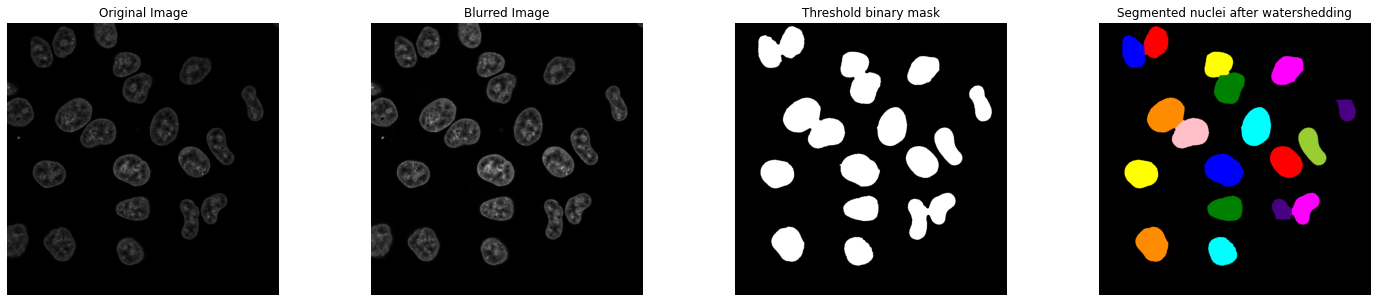

well1_2045_minus_aux_pos1-14 #02.tif


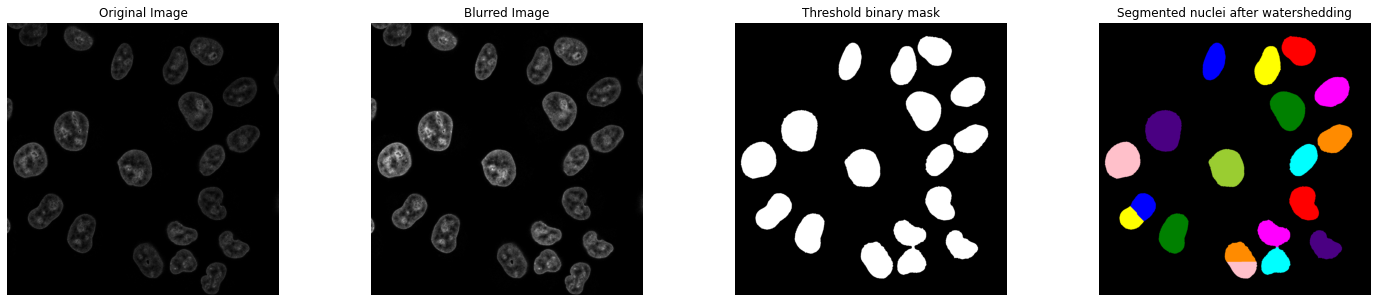

well1_2045_minus_aux_pos1-14 #03.tif


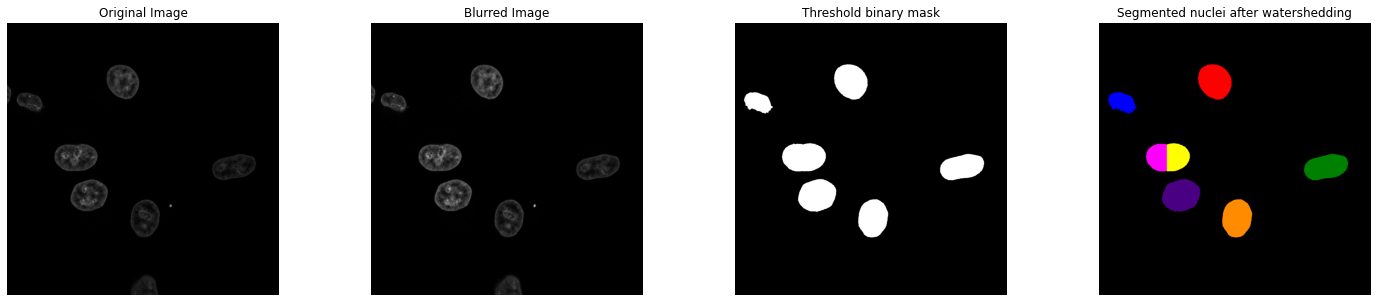

well1_2045_minus_aux_pos1-14 #04.tif


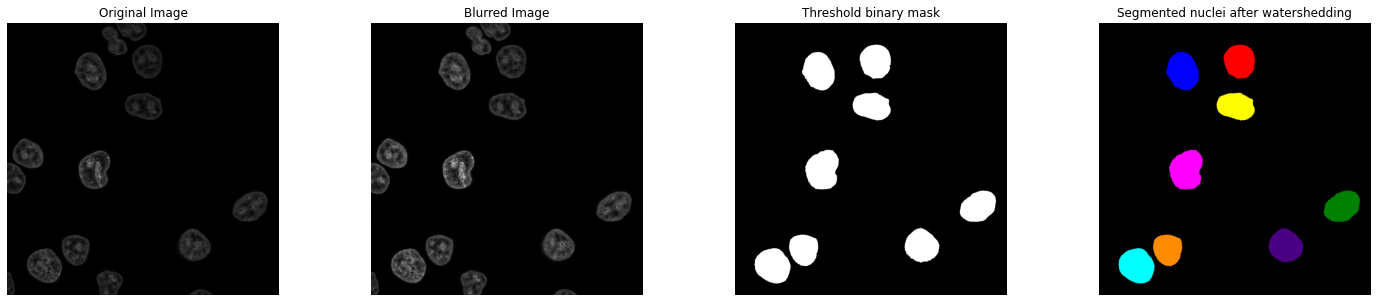

well1_2045_minus_aux_pos1-14 #05.tif


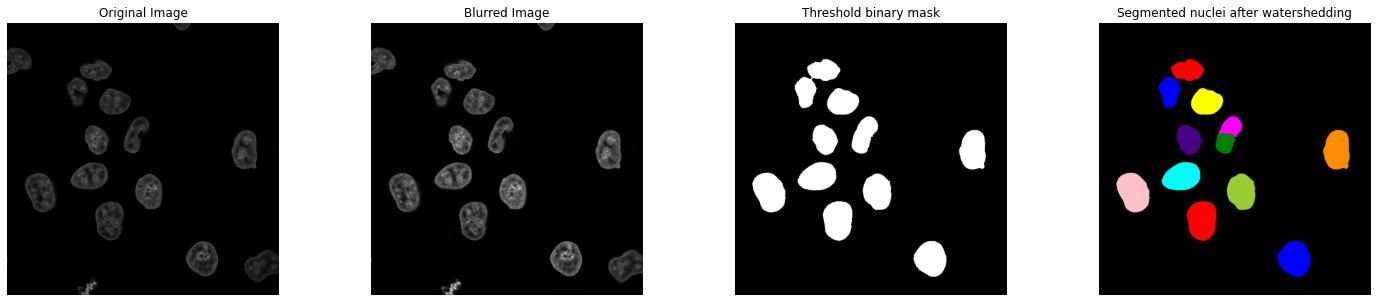

well1_2045_minus_aux_pos1-14 #06.tif


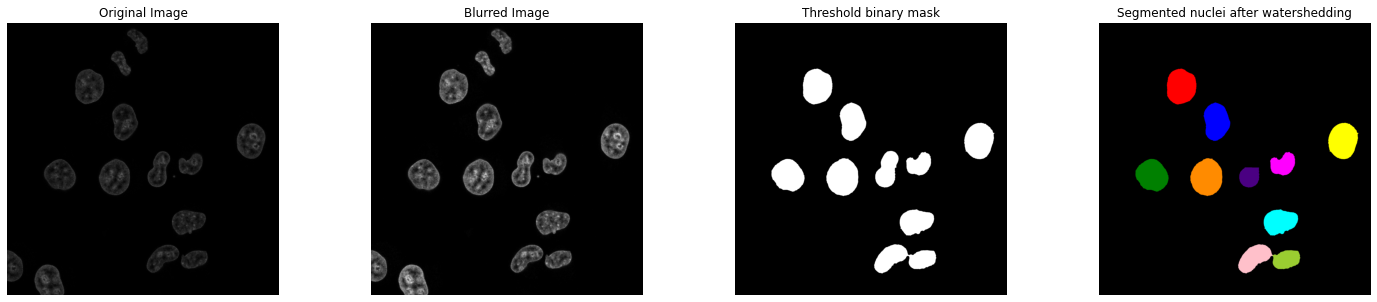

well1_2045_minus_aux_pos1-14 #07.tif


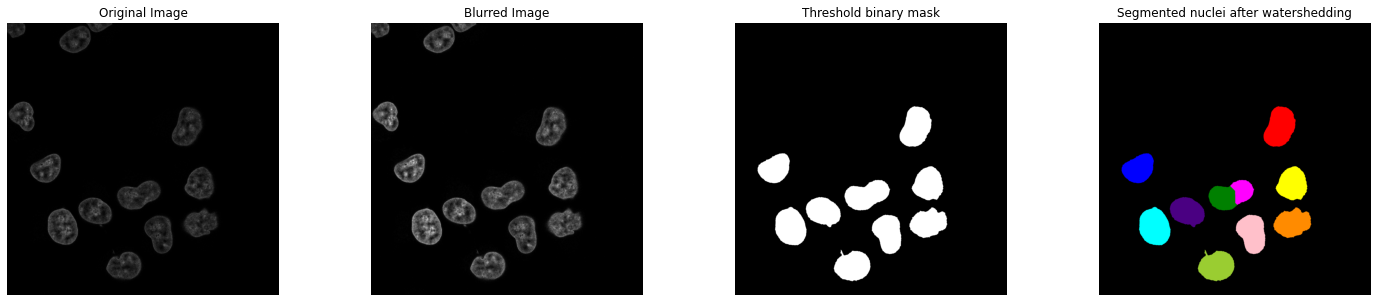

well1_2045_minus_aux_pos1-14 #08.tif


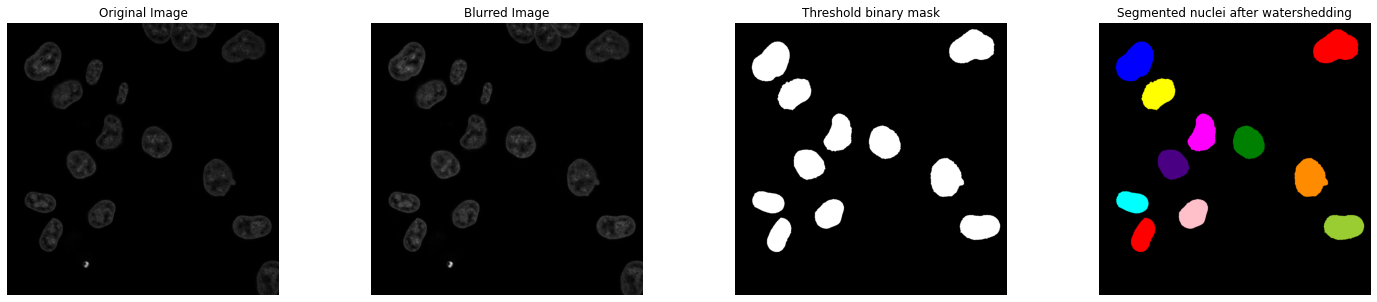

well1_2045_minus_aux_pos1-14 #09.tif


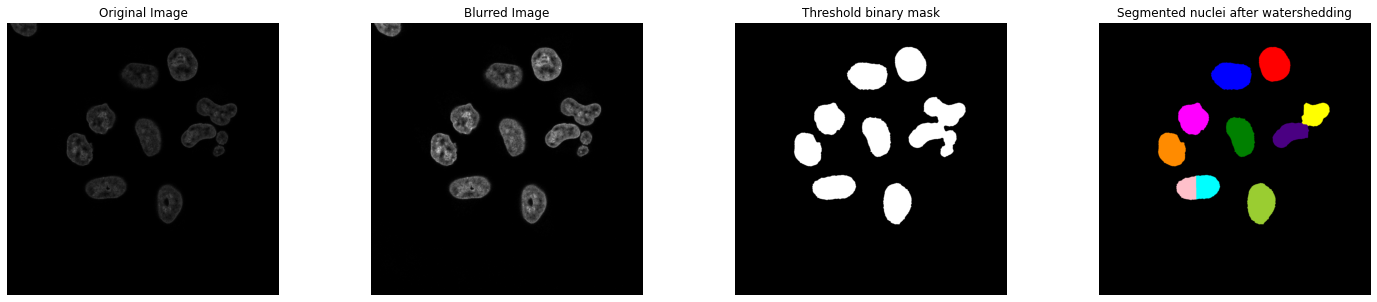

well1_2045_minus_aux_pos1-14 #10.tif


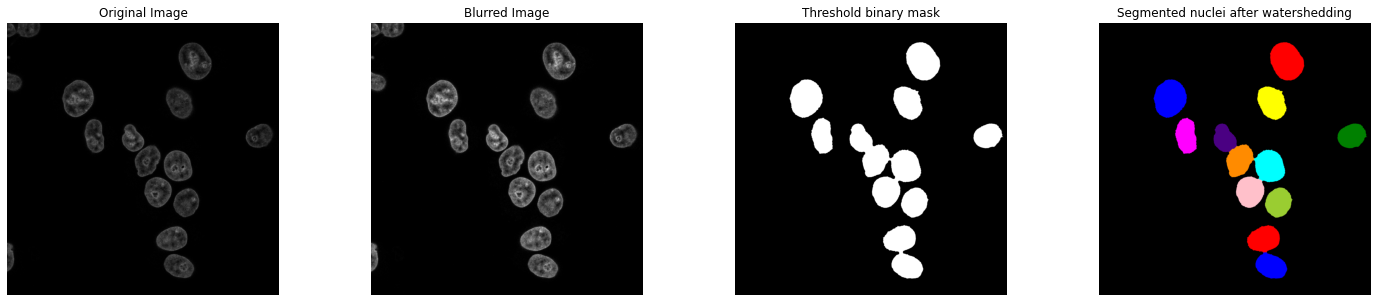

well1_2045_minus_aux_pos1-14 #11.tif


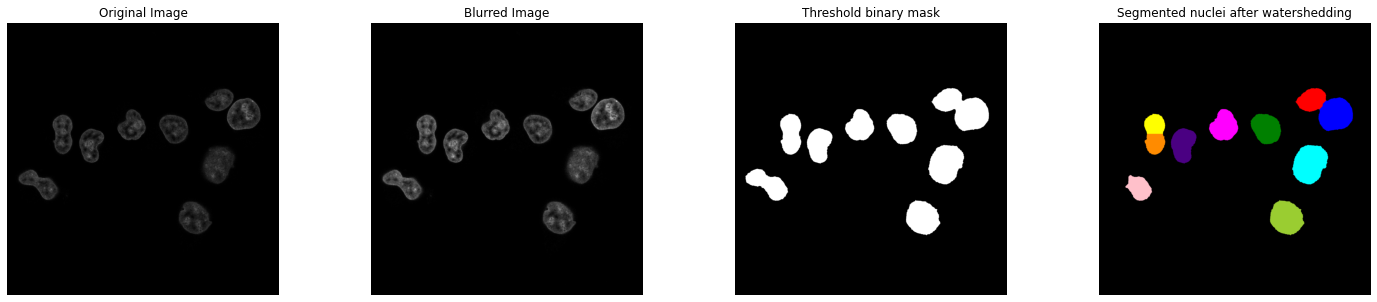

well1_2045_minus_aux_pos1-14 #12.tif


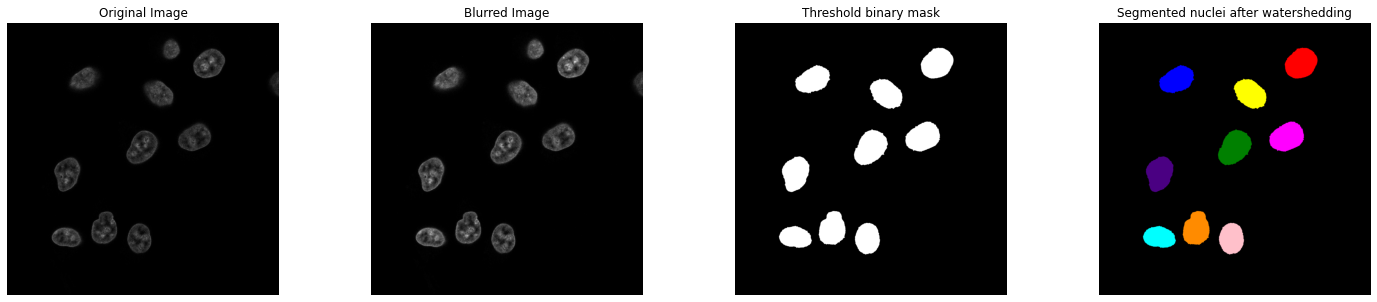

well1_2045_minus_aux_pos1-14 #13.tif


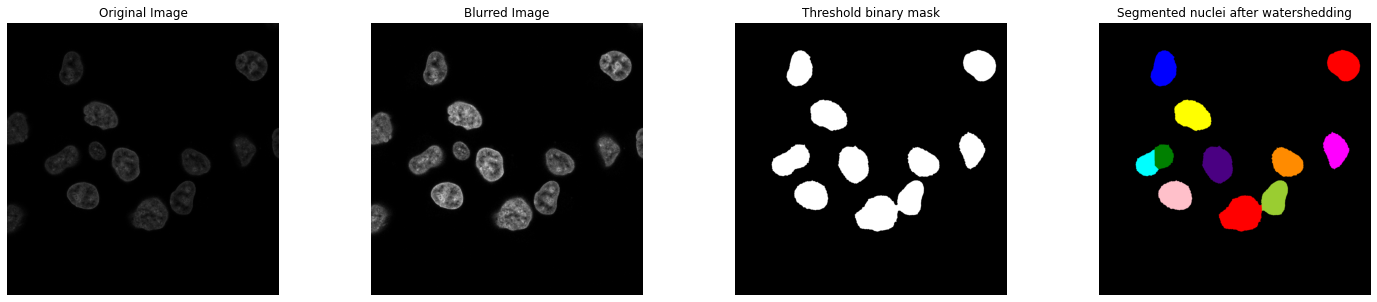

well1_2045_minus_aux_pos1-14 #14.tif


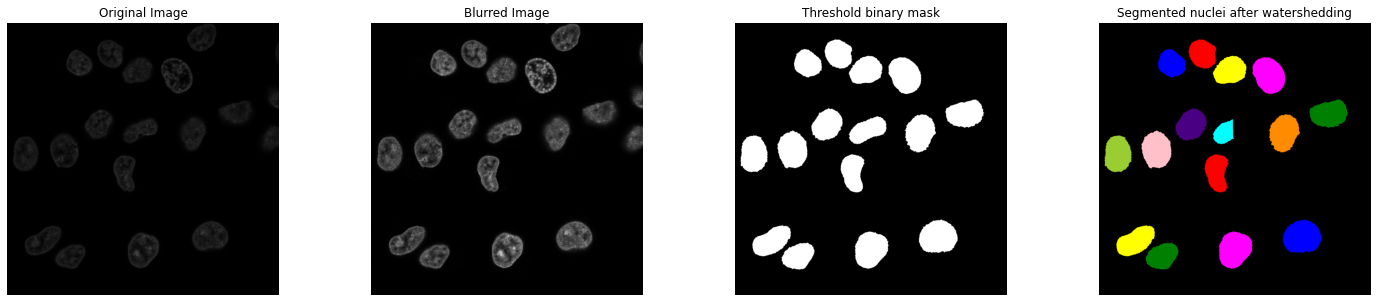

well1_2045_minus_aux_pos15-27 #01.tif


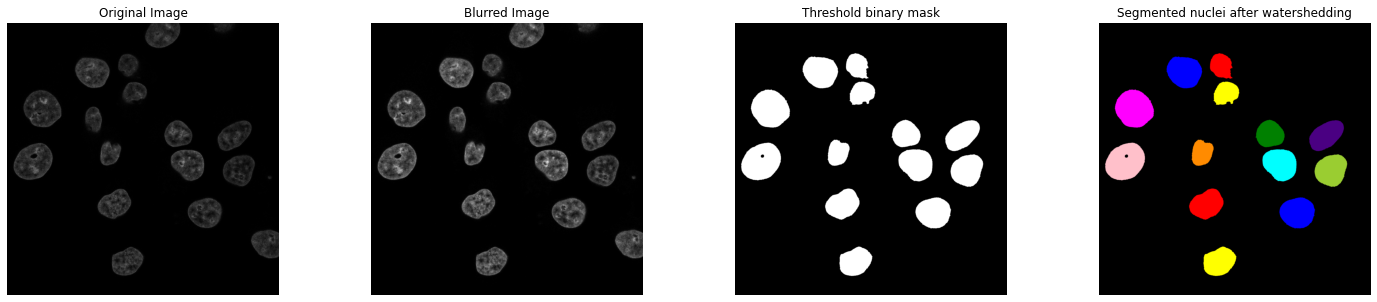

well1_2045_minus_aux_pos15-27 #02.tif


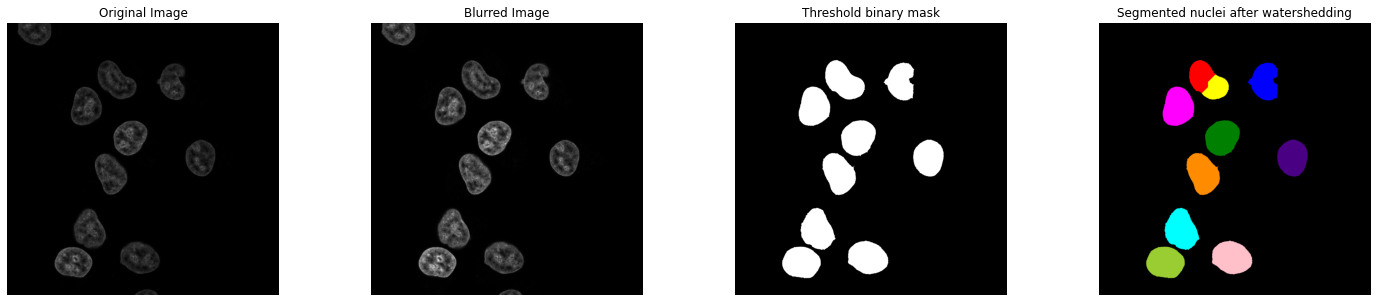

well1_2045_minus_aux_pos15-27 #03.tif


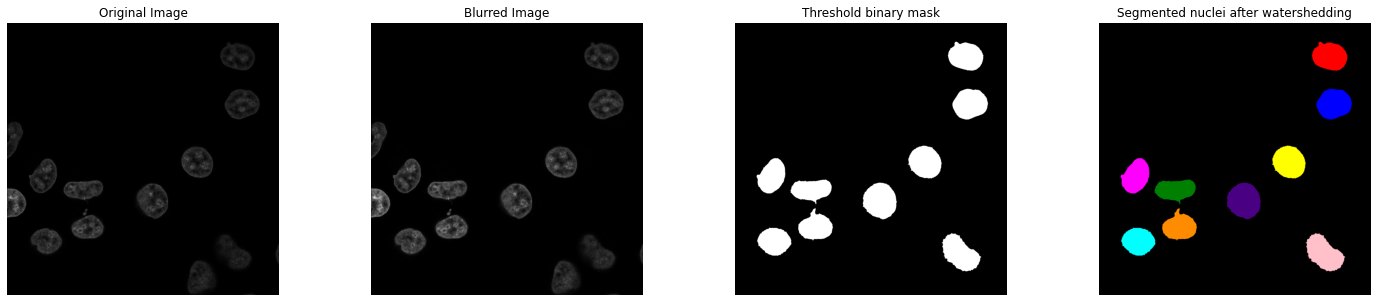

well1_2045_minus_aux_pos15-27 #04.tif


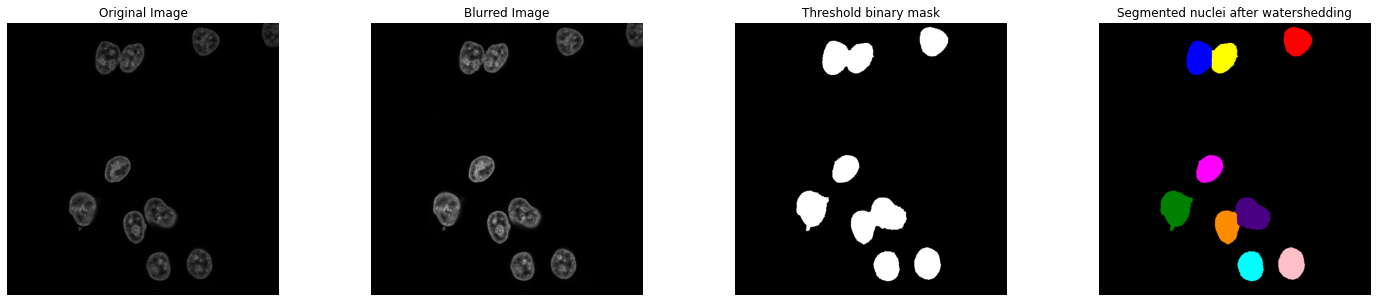

well1_2045_minus_aux_pos15-27 #05.tif


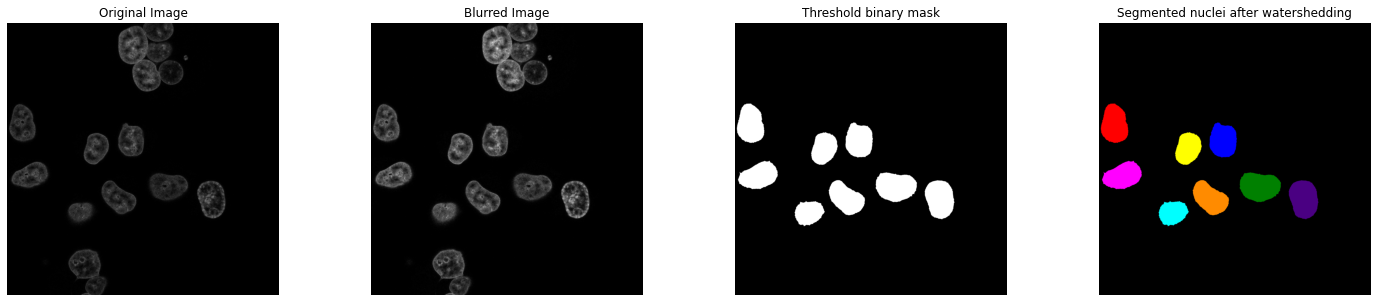

well1_2045_minus_aux_pos15-27 #06.tif


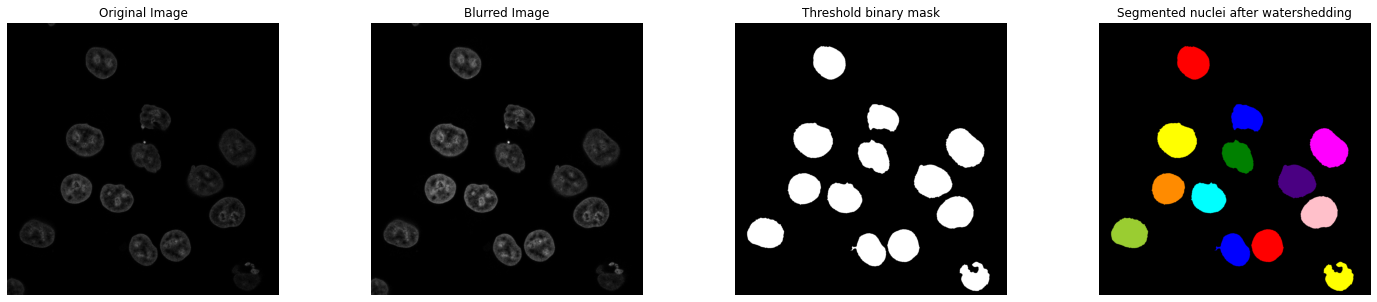

well1_2045_minus_aux_pos15-27 #07.tif


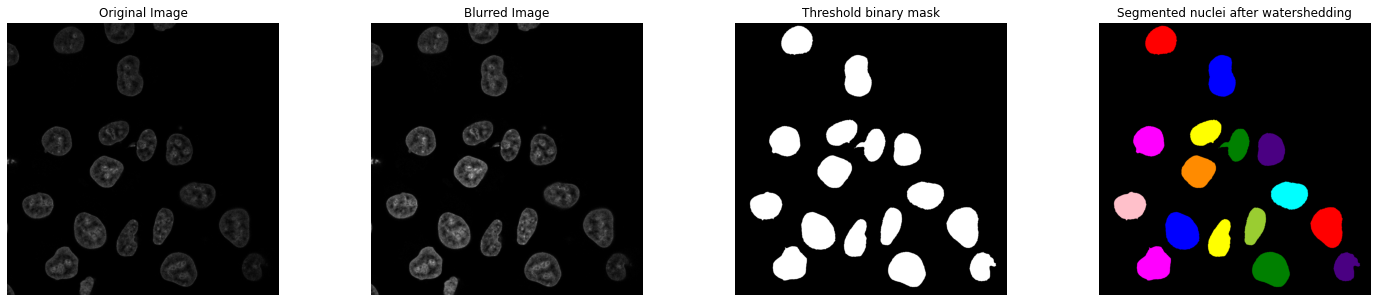

well1_2045_minus_aux_pos15-27 #08.tif


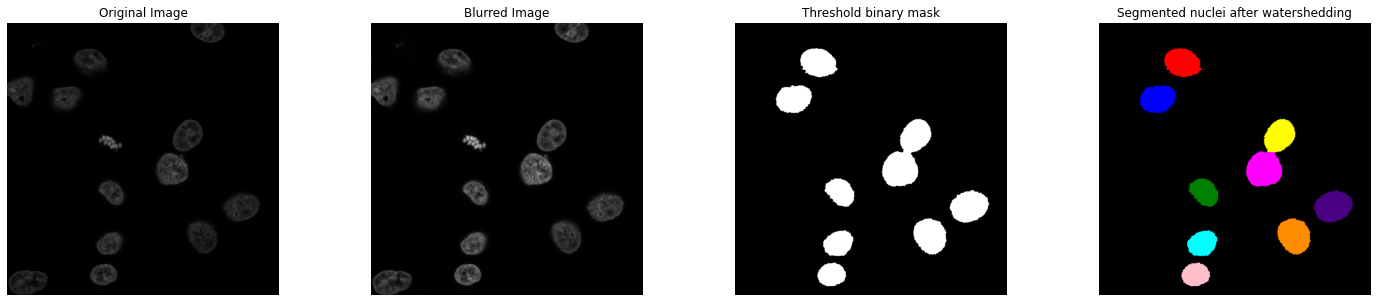

well1_2045_minus_aux_pos15-27 #09.tif


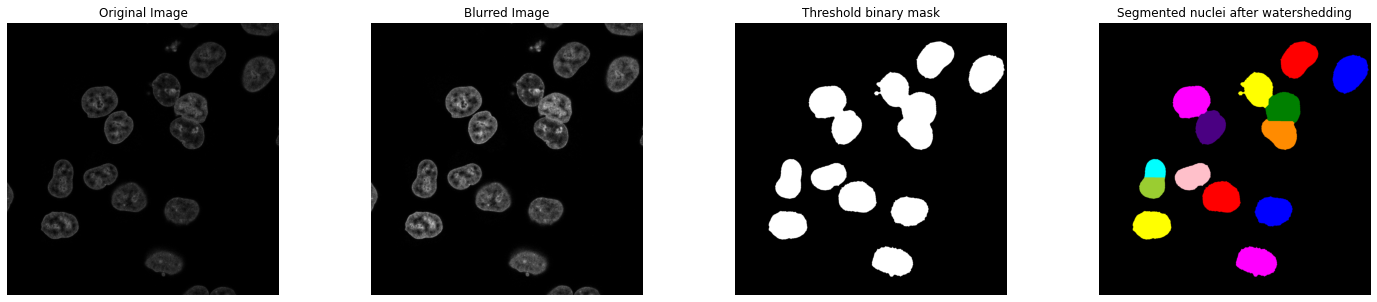

well1_2045_minus_aux_pos15-27 #10.tif


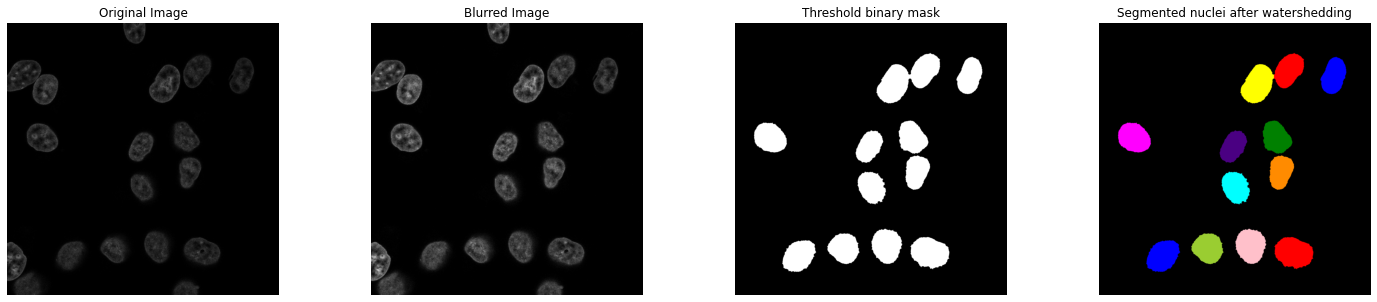

well1_2045_minus_aux_pos15-27 #11.tif


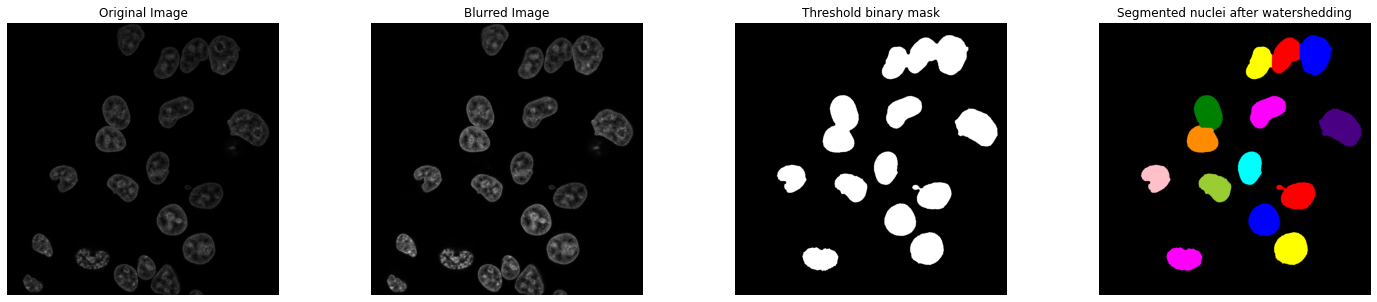

well1_2045_minus_aux_pos15-27 #12.tif


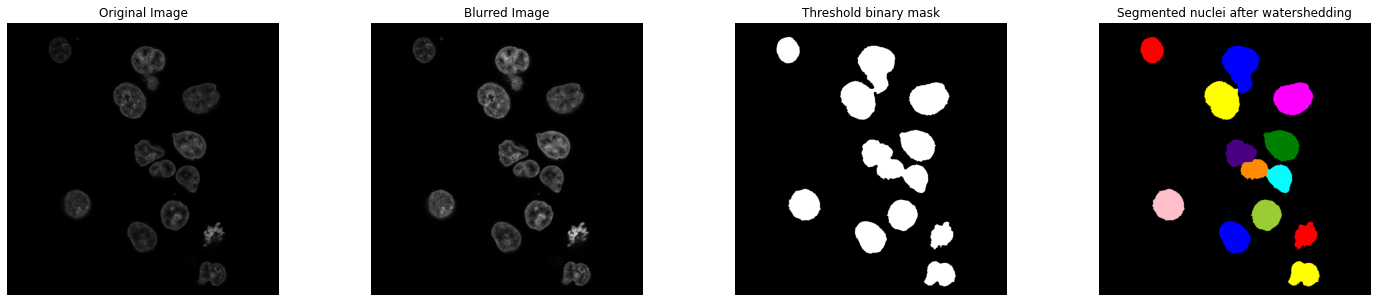

well1_2045_minus_aux_pos15-27 #13.tif


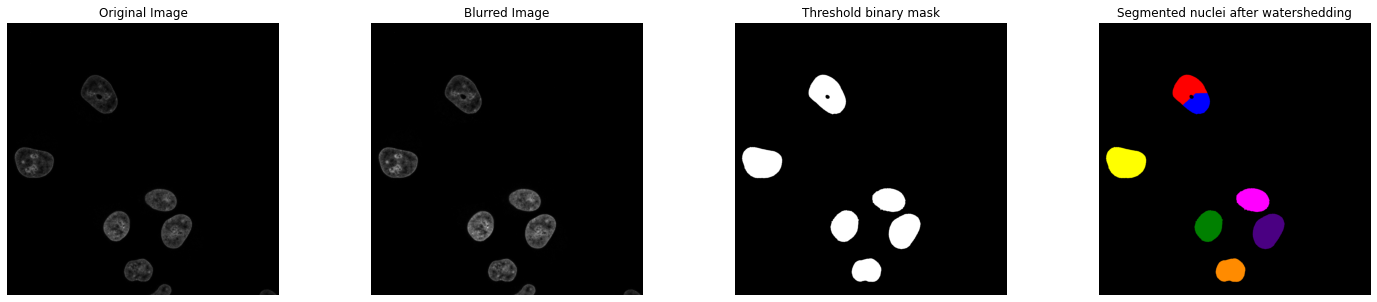

well2_2045_minus_aux_pos1-19 #01.tif


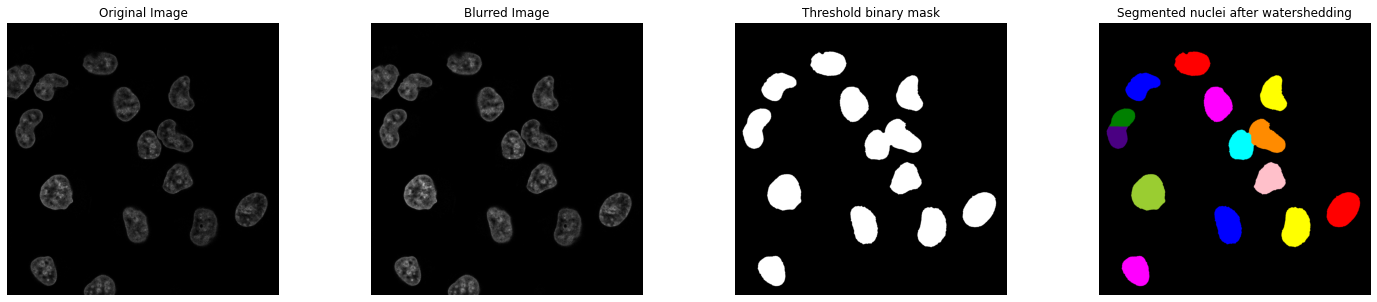

well2_2045_minus_aux_pos1-19 #02.tif


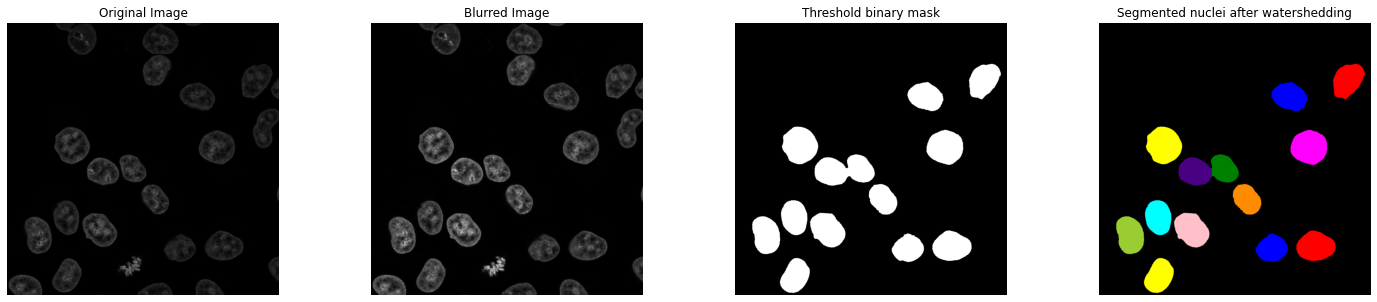

well2_2045_minus_aux_pos1-19 #03.tif


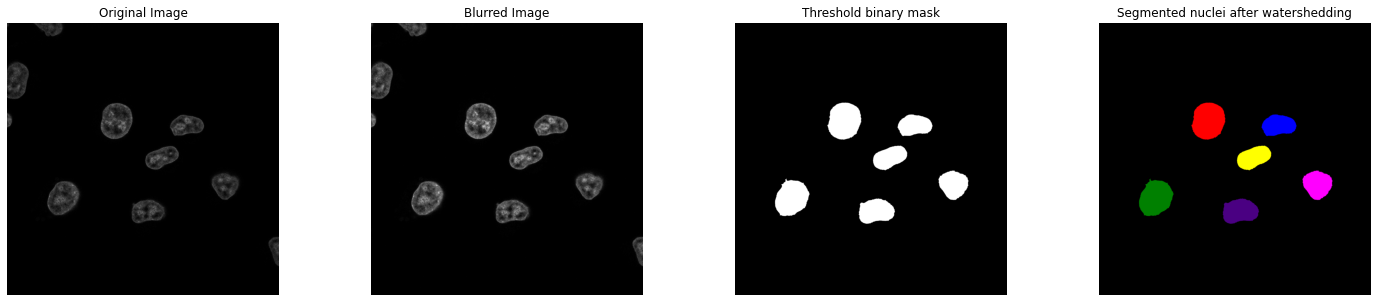

well2_2045_minus_aux_pos1-19 #04.tif


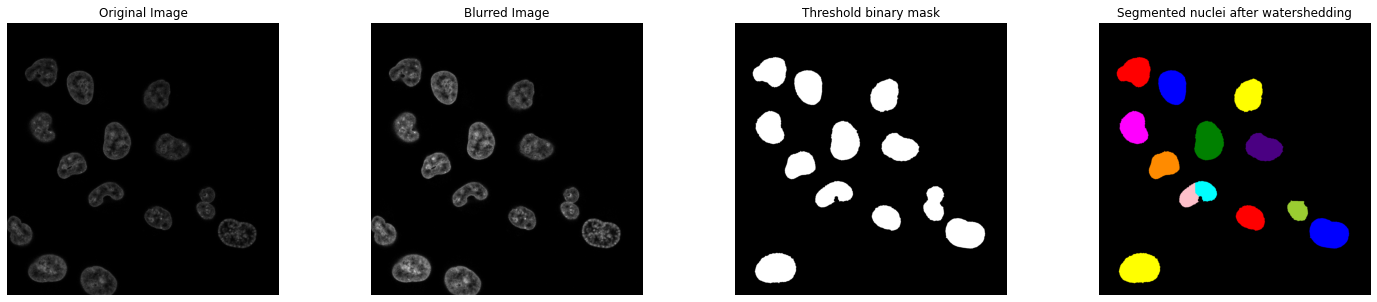

well2_2045_minus_aux_pos1-19 #05.tif


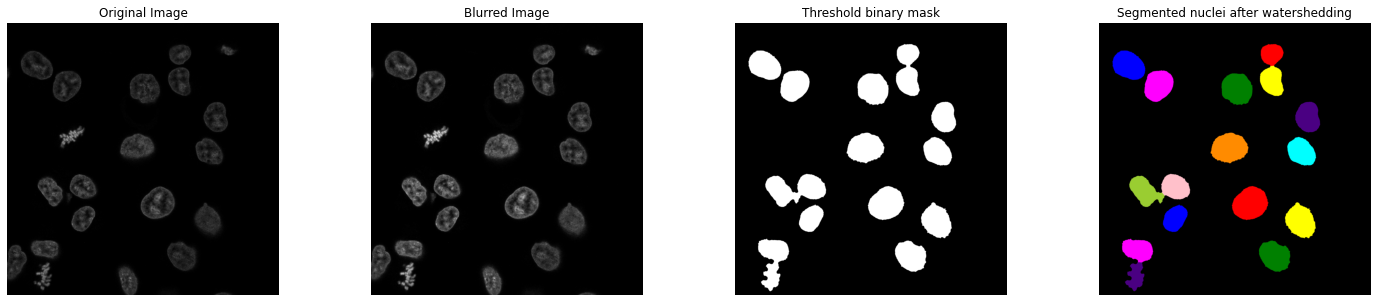

well2_2045_minus_aux_pos1-19 #11.tif


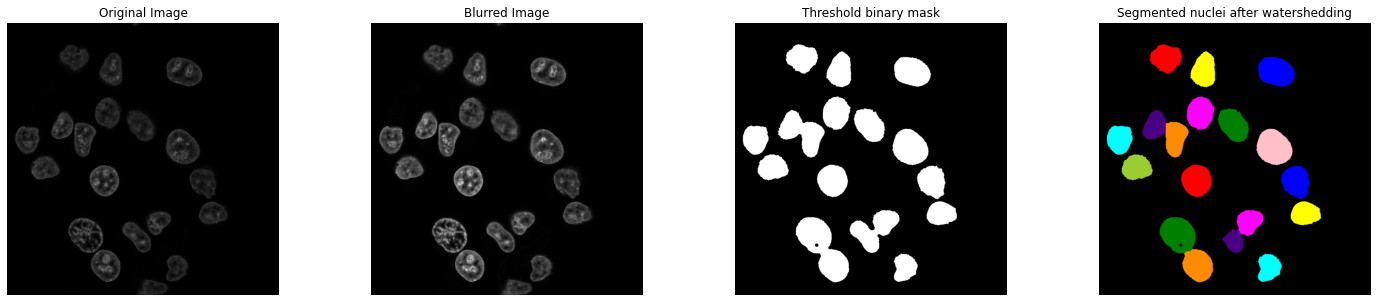

well2_2045_minus_aux_pos1-19 #06.tif


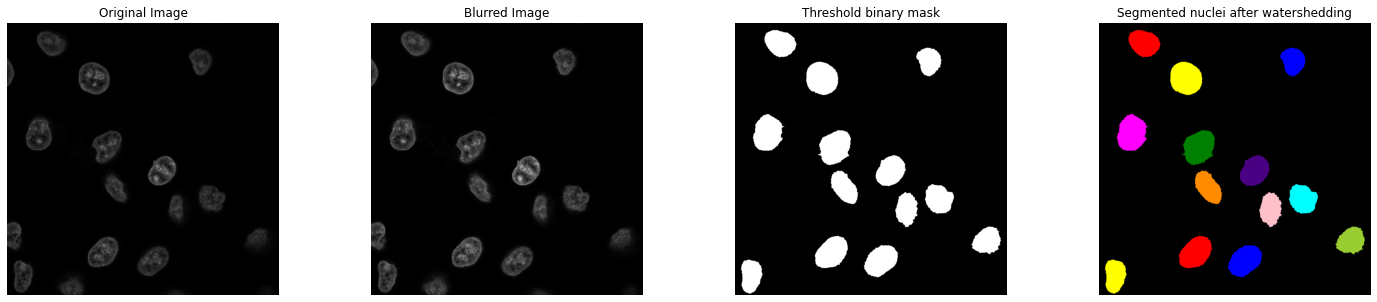

well2_2045_minus_aux_pos1-19 #07.tif


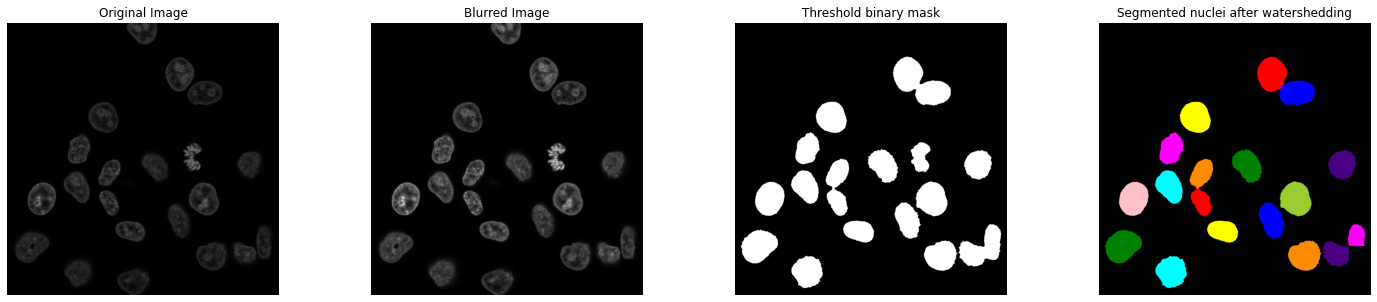

well2_2045_minus_aux_pos1-19 #08.tif


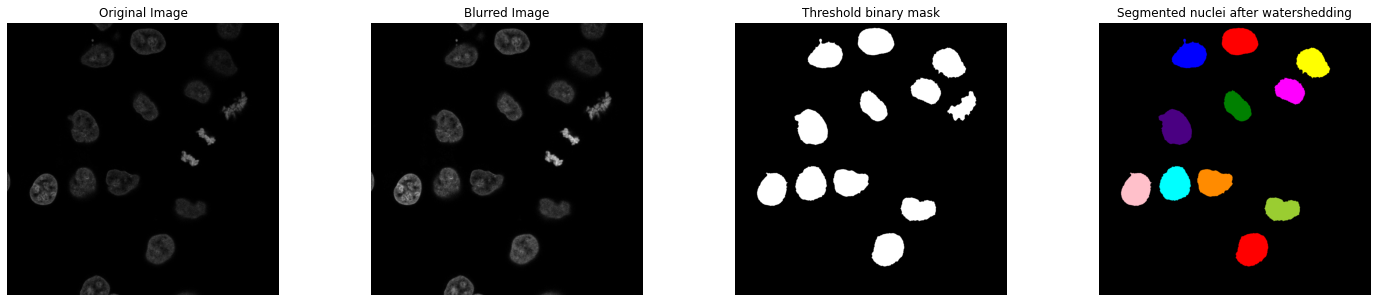

well2_2045_minus_aux_pos1-19 #09.tif


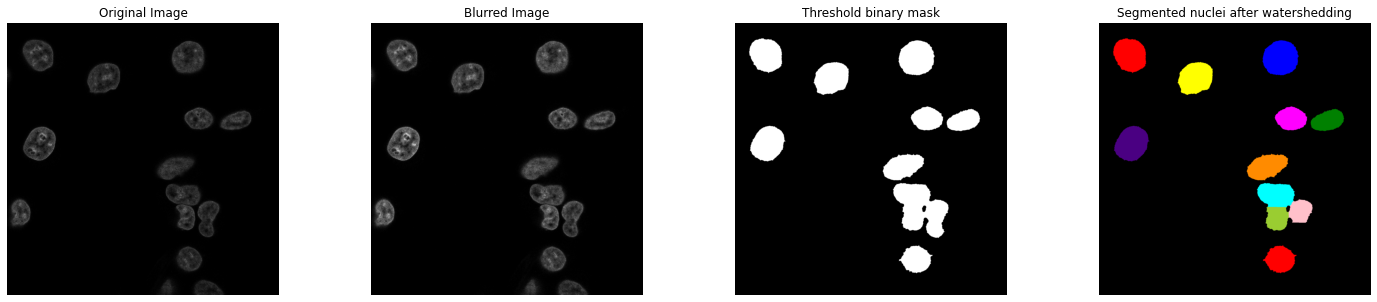

well2_2045_minus_aux_pos1-19 #10.tif


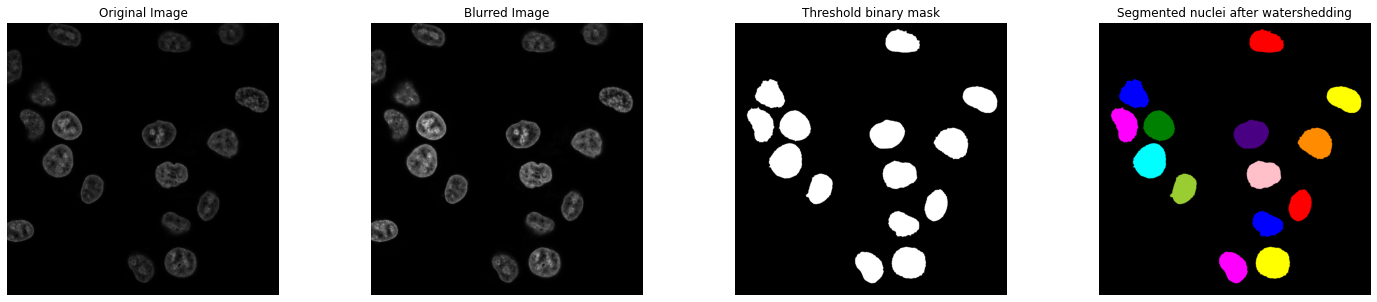

well2_2045_minus_aux_pos1-19 #12.tif


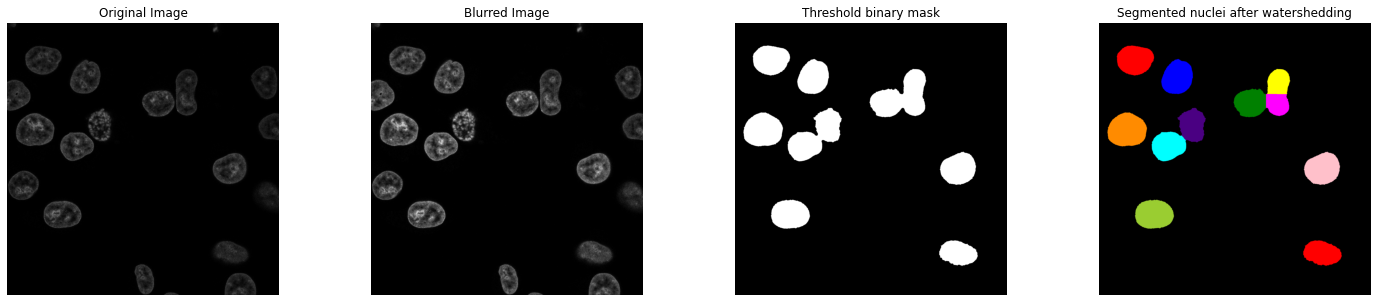

well2_2045_minus_aux_pos1-19 #13.tif


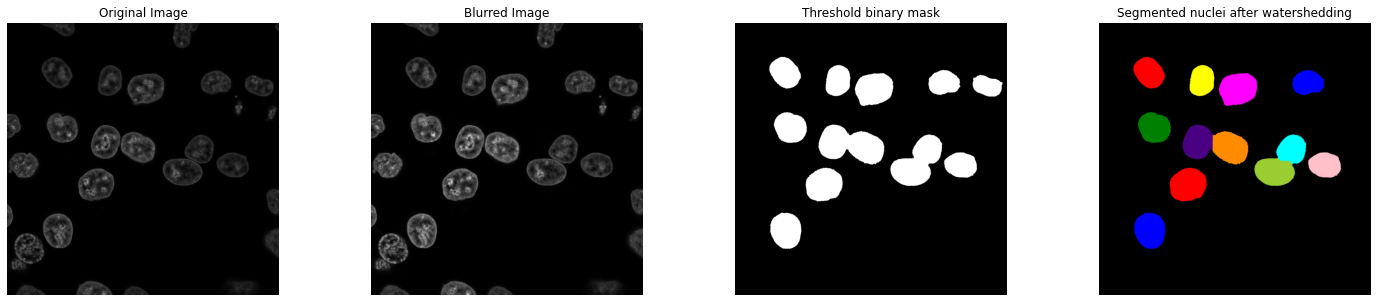

well2_2045_minus_aux_pos1-19 #14.tif


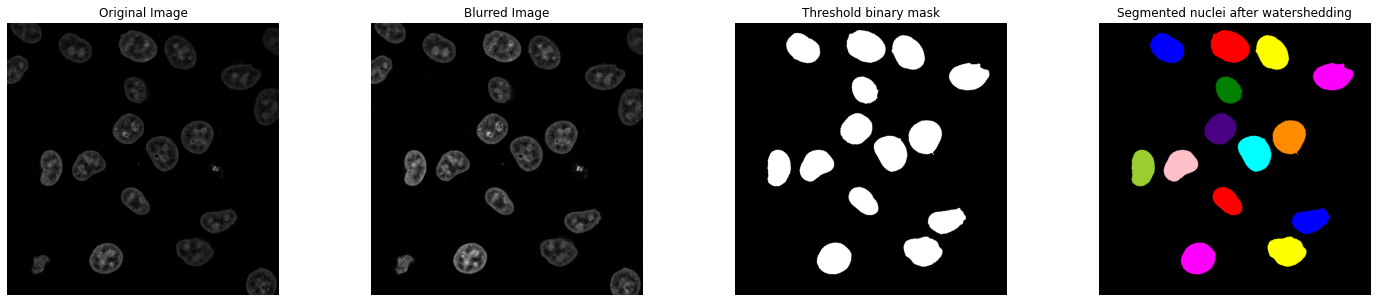

well2_2045_minus_aux_pos1-19 #15.tif


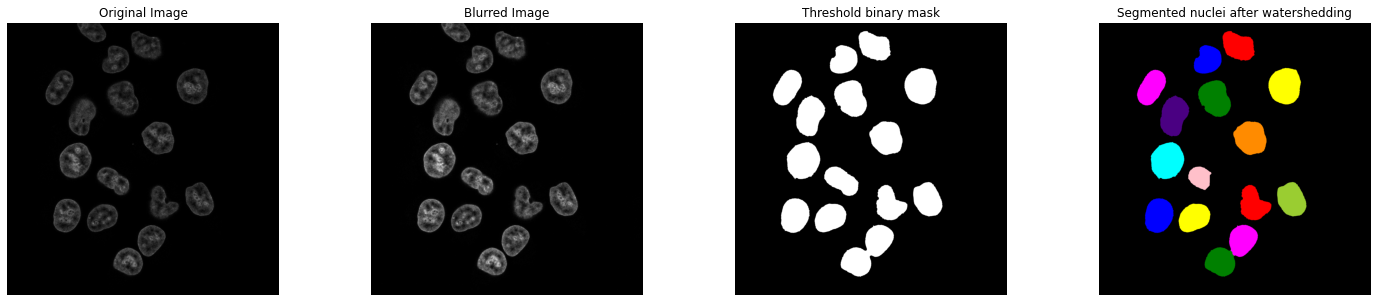

well2_2045_minus_aux_pos1-19 #16.tif


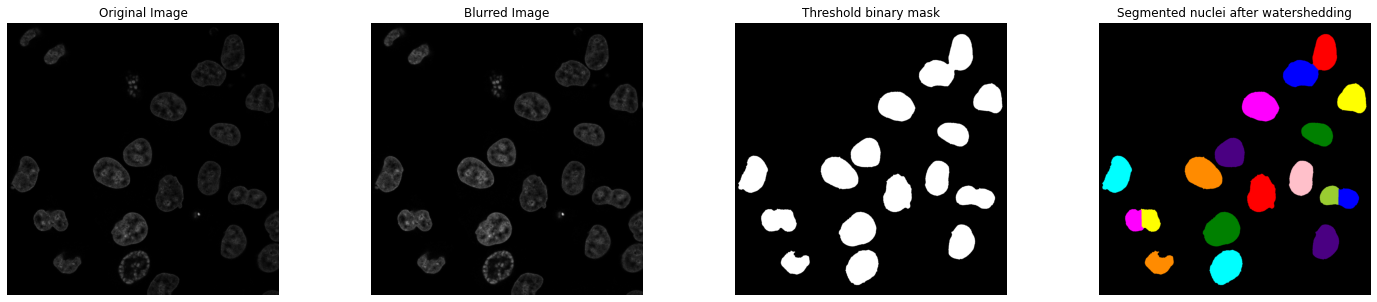

well2_2045_minus_aux_pos1-19 #17.tif


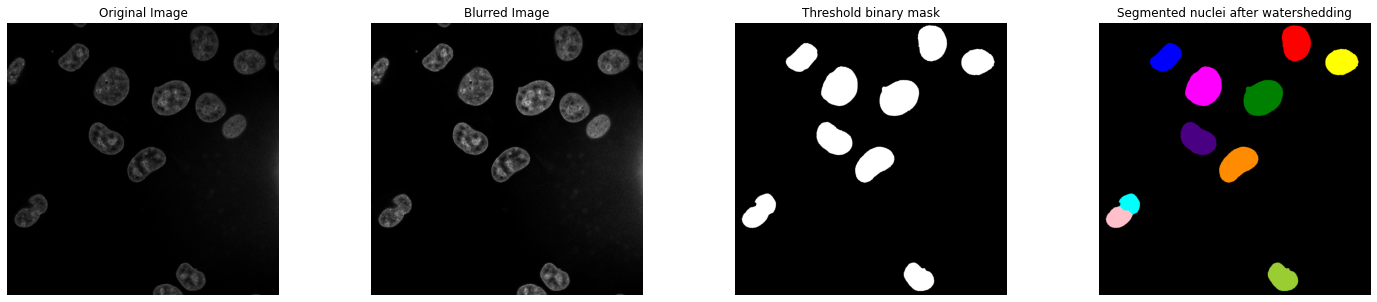

well2_2045_minus_aux_pos1-19 #18.tif


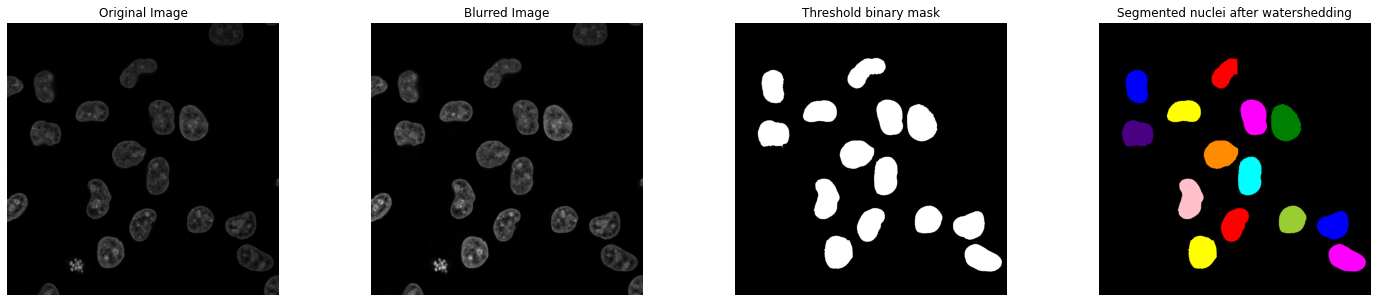

well2_2045_minus_aux_pos1-19 #19.tif


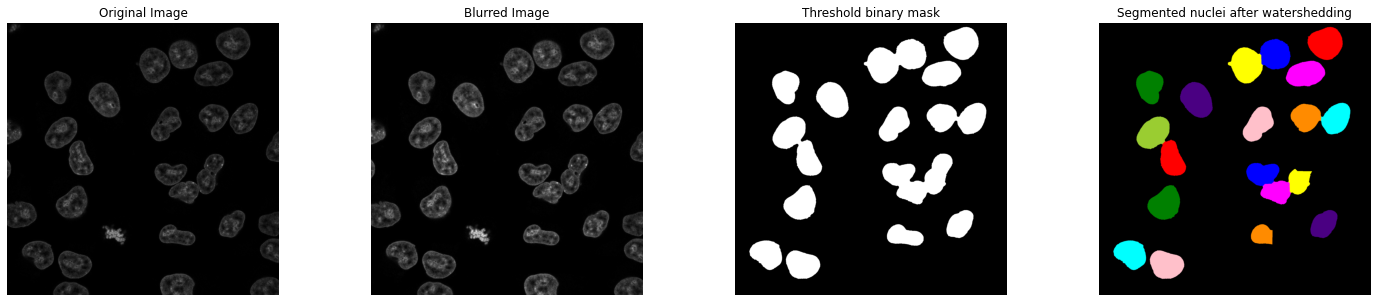

well2_2045_minus_aux_pos20-31 #01.tif


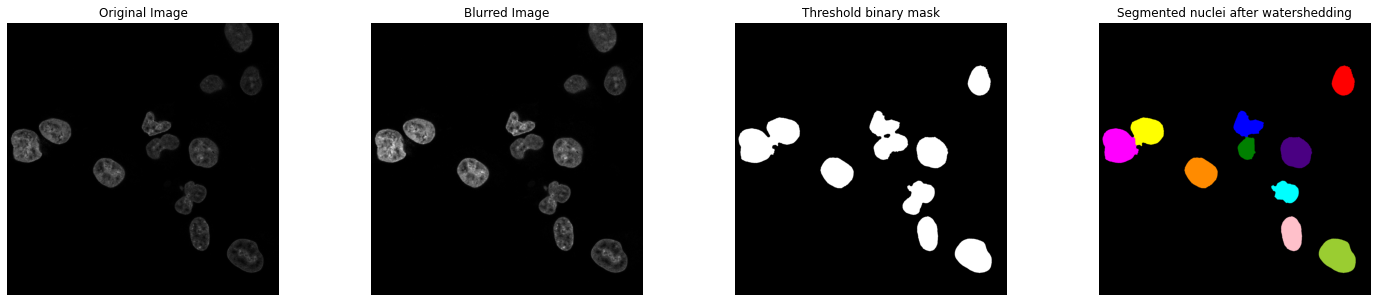

well2_2045_minus_aux_pos20-31 #02.tif


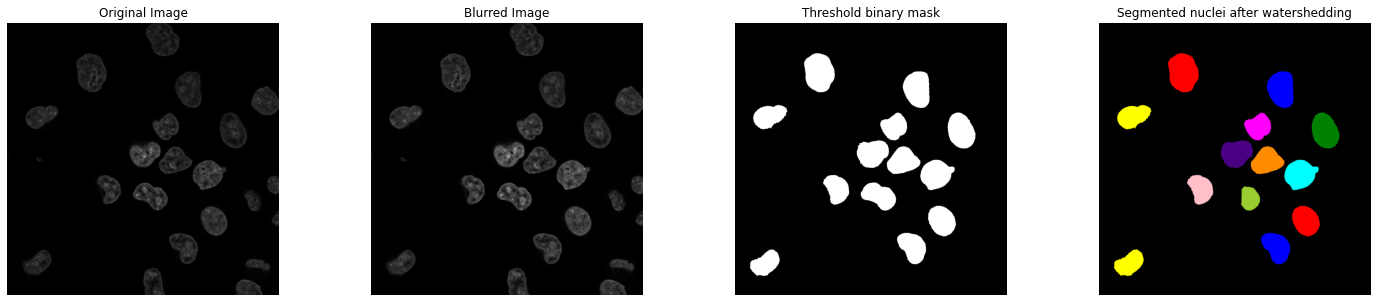

well2_2045_minus_aux_pos20-31 #03.tif


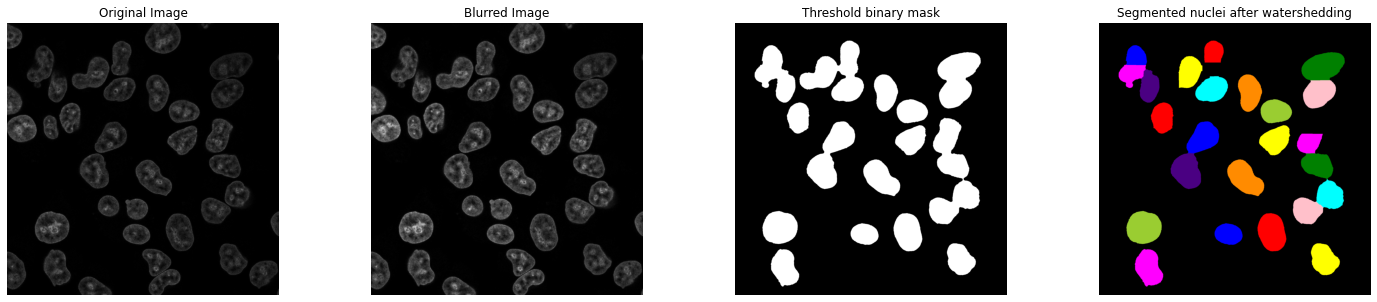

well2_2045_minus_aux_pos20-31 #04.tif


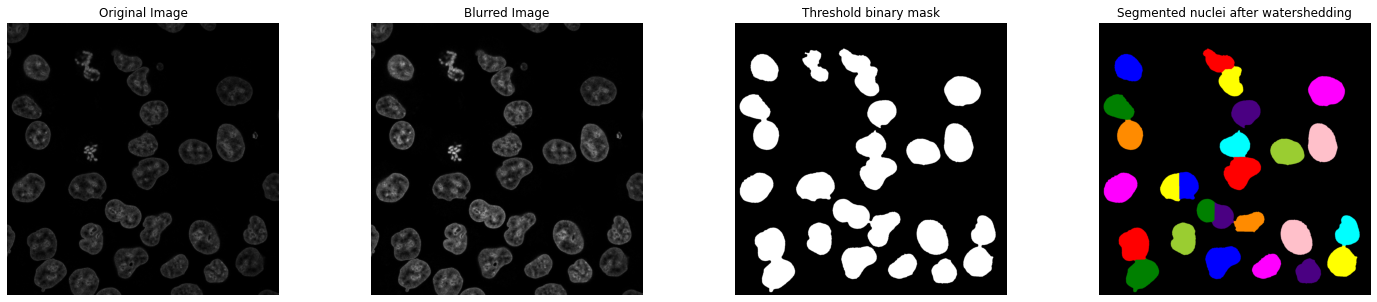

well2_2045_minus_aux_pos20-31 #05.tif


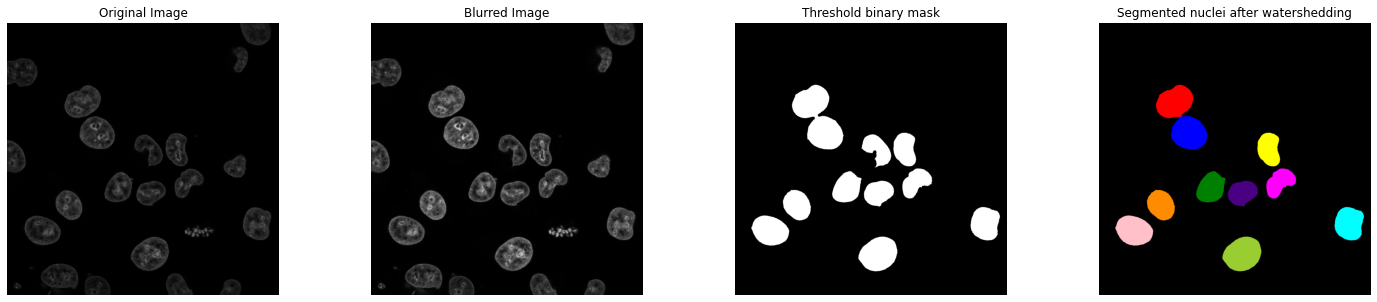

well2_2045_minus_aux_pos20-31 #06.tif


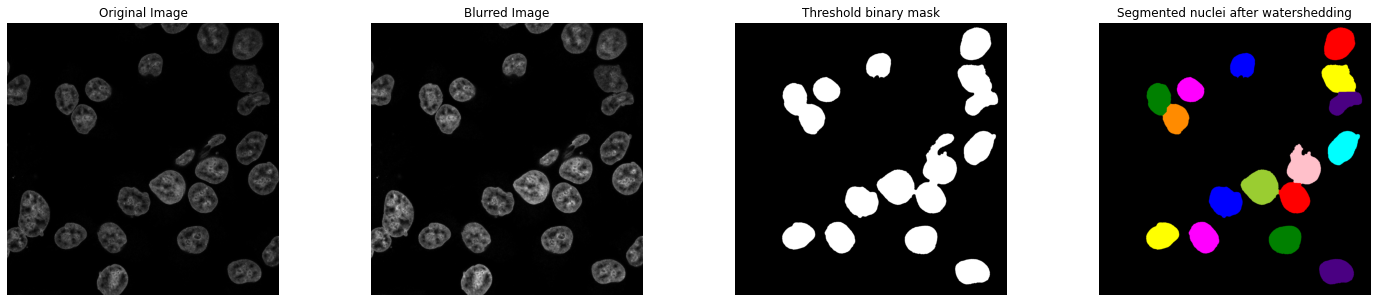

well2_2045_minus_aux_pos20-31 #07.tif


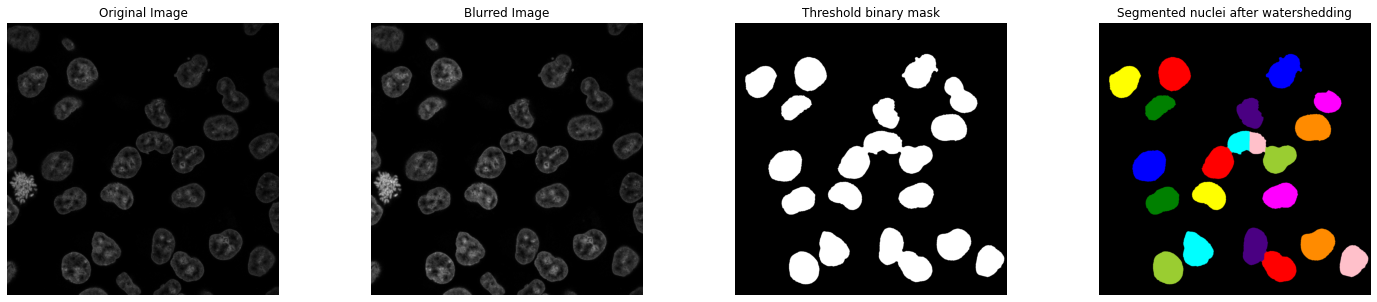

well2_2045_minus_aux_pos20-31 #08.tif


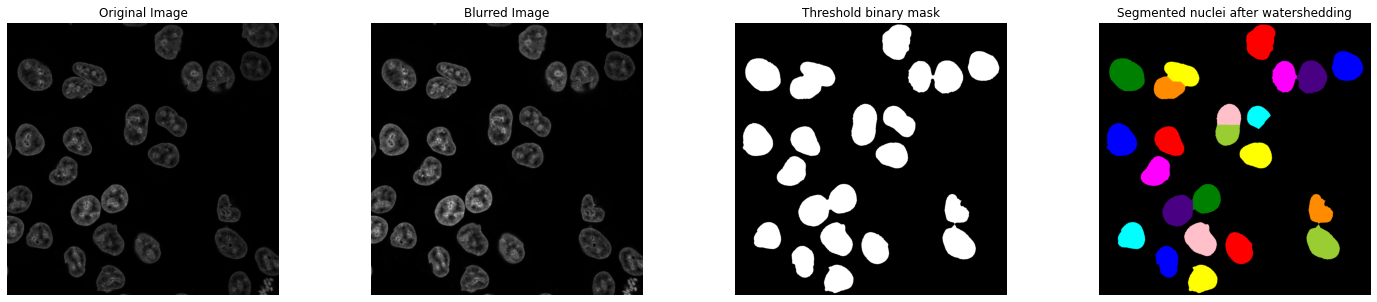

well2_2045_minus_aux_pos20-31 #09.tif


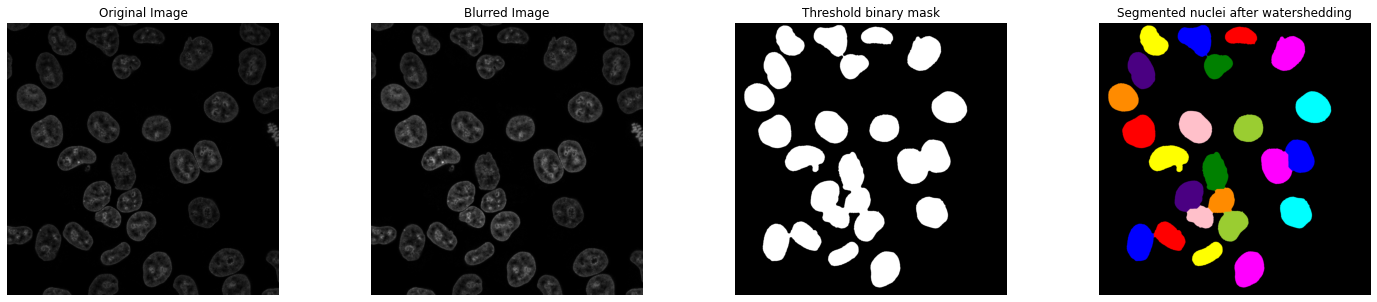

well2_2045_minus_aux_pos20-31 #10.tif


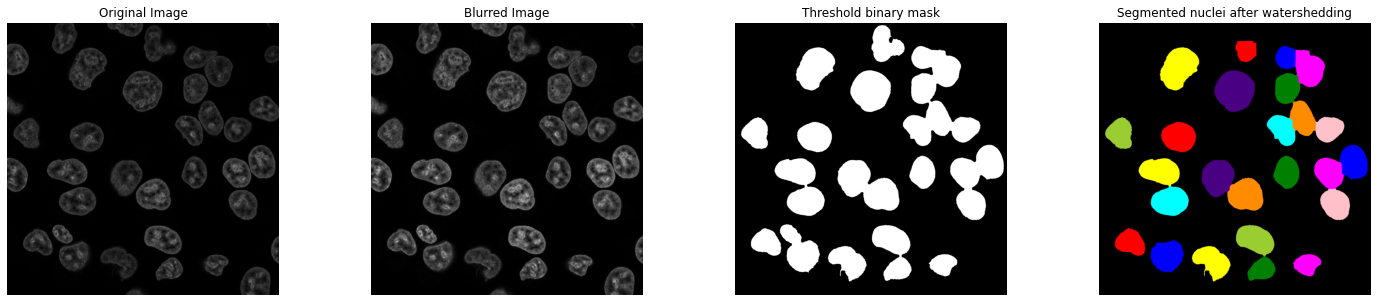

well2_2045_minus_aux_pos20-31 #12.tif


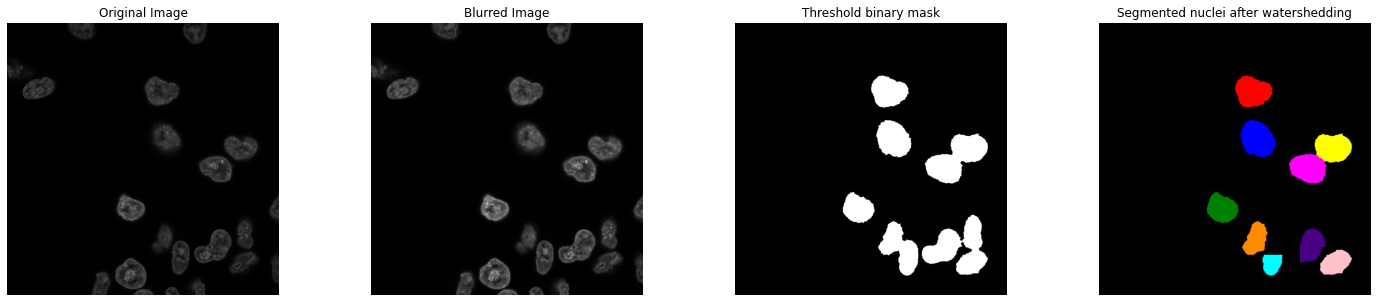

well2_2045_minus_aux_pos20-31 #11.tif


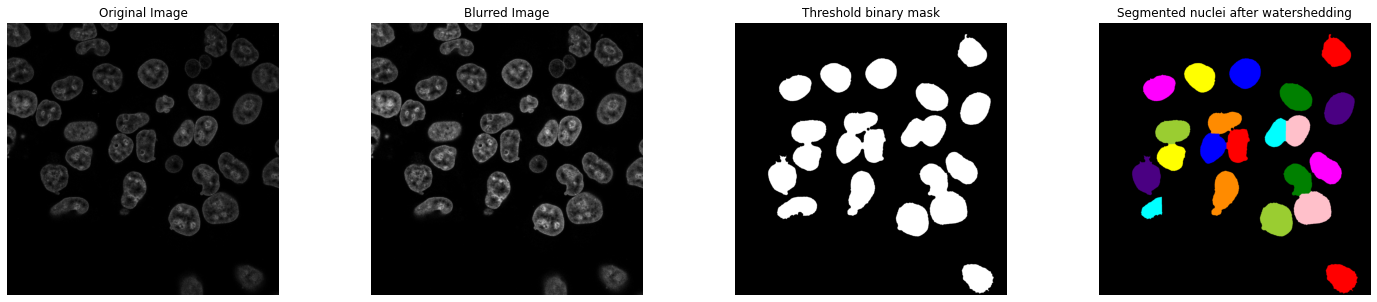

In [26]:
inpath = ("/groups/gerlich/experiments/Experiments_005600/005606/images/tifs/attempt3_220915/2045_minus_aux/")
os.chdir(inpath)
images = glob('*.tif', recursive=True)
result = threshold_field(images)

#data = io.imread("/groups/gerlich/experiments/Experiments_005200/005223/Images/Projections/short_g2_scc1_smc4/2108_zoom5_0_control_short_G2_cycB1_SMC4_Scc1_EGFP_Hoechst-02-64.czi #1.tif_registered.tif")

In [27]:
result

image_name  nuclear_area_microns  mean_hoechst  \
0   well2_2045_minus_aux_pos20-31 #11.tif            146.307279     18.964725   
1   well2_2045_minus_aux_pos20-31 #11.tif            146.028304     17.464163   
2   well2_2045_minus_aux_pos20-31 #11.tif            145.440464     22.430724   
3   well2_2045_minus_aux_pos20-31 #11.tif            172.261888     17.066948   
4   well2_2045_minus_aux_pos20-31 #11.tif            182.245196     19.236941   
..                                    ...                   ...           ...   
15  well2_2045_minus_aux_pos20-31 #11.tif            158.412787     19.826347   
16  well2_2045_minus_aux_pos20-31 #11.tif            199.616352     21.528750   
17  well2_2045_minus_aux_pos20-31 #11.tif            244.043071     19.513514   
19  well2_2045_minus_aux_pos20-31 #11.tif            212.578712     23.693616   
20  well2_2045_minus_aux_pos20-31 #11.tif            161.949788     13.193700   

    mean_nipbl  total_hoechst  total_nuclear_nipbl  std_hoechst  std_nipbl  \
0    17.710783    2774.677262          2591.216533    11.074270  15.575500   
1    18.523351    2550.262052          2704.933590    11.273000  16.076726   
2    19.368693    3262.334979          2816.991744    12.608326  16.723396   
3    16.491281    2939.984709          2840.819171    10.144380  14.434188   
4    18.636826    3505.840028          3396.471987    11.778490  16.042670   
..         ...            ...                  ...          ...        ...   
15   19.047266    3140.746851          3017.330441    11.679687  15.589347   
16   16.796381    4297.490485          3352.832375    13.914343  14.167842   
17   17.268413    4762.137772          4214.236467    10.889757  14.612903   
19   17.097136    5036.758462          3634.487213    13.654541  14.626246   
20   15.822172    2136.716950          2562.397451     8.935951  14.005783   

    coeff_variance_hoechst  coeff_variance_nipbl         condition  
0                 0.583940              0.879436  2045_minus_auxin  
1                 0.645493              0.867917  2045_minus_auxin  
2                 0.562101              0.863424  2045_minus_auxin  
3                 0.594387              0.875262  2045_minus_auxin  
4                 0.612285              0.860805  2045_minus_auxin  
..                     ...                   ...               ...  
15                0.589099              0.818456  2045_minus_auxin  
16                0.646314              0.843506  2045_minus_auxin  
17                0.558062              0.846222  2045_minus_auxin  
19                0.576296              0.855479  2045_minus_auxin  
20                0.677289              0.885200  2045_minus_auxin  

[690 rows x 11 columns]

In [20]:
# Testing thresholding on single image using cellpose and napari

# To do, use command line and cell pose to apply thresholding to a folder of cells

In [14]:
data = io.imread("/groups/gerlich/experiments/Experiments_005600/005606/images/tifs/2096_minus_dtag/2096_minus_dtag_stain_hoechst_scc1_pos1-6 #06.tif")
#mask = io.imread("/groups/gerlich/experiments/Experiments_005000/005003/TIFs_registered_background_subtracted_testing/WT_fully_noR/Rep1/1/slices/20/Mask.tif")
print("shape: {}".format(data.shape))
print("dtype: {}".format(data.dtype))
print("range: ({}, {})".format(data.min(), data.max()))

#print("m shape: {}".format(mask.shape))
#print("m dtype: {}".format(mask.dtype))
#print("m range: ({}, {})".format(mask.min(), mask.max()))

shape: (2, 1912, 1912)
dtype: uint8
range: (0, 255)


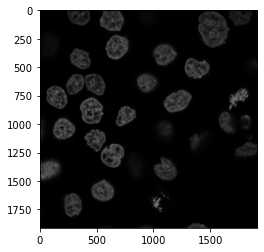

In [15]:
hoechst = data[0,:,:]
scc1 = data[1,:,:]
#wapl_ha = data[:,:,2]
display_slice(hoechst)
